<a href="https://colab.research.google.com/github/nicolez9911/colab/blob/main/04_melanoma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=90e5ea35fe53c862c2e91afa76d9711c910c93205d99ee52492b44b596e0c0e8
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nicolez9911","key":"439a3da38e3dab16713f10b91119c5cf"}'}

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [3]:
!kaggle datasets download -d drscarlat/melanoma

100% 5.25G/5.26G [00:55<00:00, 96.0MB/s]
100% 5.26G/5.26G [00:55<00:00, 101MB/s] 


In [4]:
!unzip -qq /content/melanoma.zip

In [ ]:
!ls /content

dermmel  DermMel  kaggle.json  melanoma.zip  sample_data


In [5]:
import matplotlib.pyplot as plt

def generate_plot(history):
  # Plot training history (loss and accuracy)
  plt.figure(figsize=(12, 5))

  # Plot training & validation loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')

  # Plot training & validation accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Training and Validation Accuracy')

  plt.tight_layout()
  return plt

## Load Dataset

### Image Info

In [6]:
# import required module
from PIL import Image

# get image
filepath = "/content/dermmel/DermMel/train_sep/Melanoma/AUG_0_10.jpeg"
img = Image.open(filepath)

# get width and height
width = img.width
height = img.height

# display width and height
print("The height of the image is: ", height)
print("The width of the image is: ", width)


The height of the image is:  224
The width of the image is:  224


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

common_image_size = (224, 224)

datagen = ImageDataGenerator(
      rescale=1./255,
      zoom_range=0.2,
      fill_mode='nearest',
      horizontal_flip=True,
      vertical_flip=True
)

batch_size = 32

train_dataset = datagen.flow_from_directory(
    "DermMel/train_sep",
    target_size=common_image_size,
    batch_size=batch_size,
    class_mode='binary' # or 'categorical' depending on your problem
)
validation_dataset = datagen.flow_from_directory(
    "DermMel/valid",
    target_size=common_image_size,
    batch_size=batch_size,
    class_mode='binary'
)
test_dataset = datagen.flow_from_directory(
    "DermMel/test",
    target_size=common_image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 10682 images belonging to 2 classes.
Found 3562 images belonging to 2 classes.
Found 3561 images belonging to 2 classes.


In [ ]:
from matplotlib import pyplot
pyplot.imshow(train_dataset[0][0][10])

## create model with freezed base model

In [10]:
from tensorflow import keras
from keras import layers

# Load the VGG16 model pre-trained on ImageNet data
base_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of VGG16
model = keras.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))  # for binary classification

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy']
)

## train with freezed base model

Epoch 1/10
333/333 [==============================] - 336s 955ms/step - loss: 0.7015 - accuracy: 0.7405 - val_loss: 0.3986 - val_accuracy: 0.8136
Epoch 2/10
333/333 [==============================] - 259s 779ms/step - loss: 0.4294 - accuracy: 0.8038 - val_loss: 0.3761 - val_accuracy: 0.8300
Epoch 3/10
333/333 [==============================] - 256s 770ms/step - loss: 0.4006 - accuracy: 0.8209 - val_loss: 0.3400 - val_accuracy: 0.8421
Epoch 4/10
333/333 [==============================] - 274s 822ms/step - loss: 0.3874 - accuracy: 0.8283 - val_loss: 0.3344 - val_accuracy: 0.8471
Epoch 5/10
333/333 [==============================] - 271s 814ms/step - loss: 0.3709 - accuracy: 0.8334 - val_loss: 0.3387 - val_accuracy: 0.8454
Epoch 6/10
333/333 [==============================] - 253s 759ms/step - loss: 0.3613 - accuracy: 0.8416 - val_loss: 0.3504 - val_accuracy: 0.8392
Epoch 7/10
333/333 [==============================] - 273s 822ms/step - loss: 0.3579 - accuracy: 0.8422 - val_loss: 0.3084 -

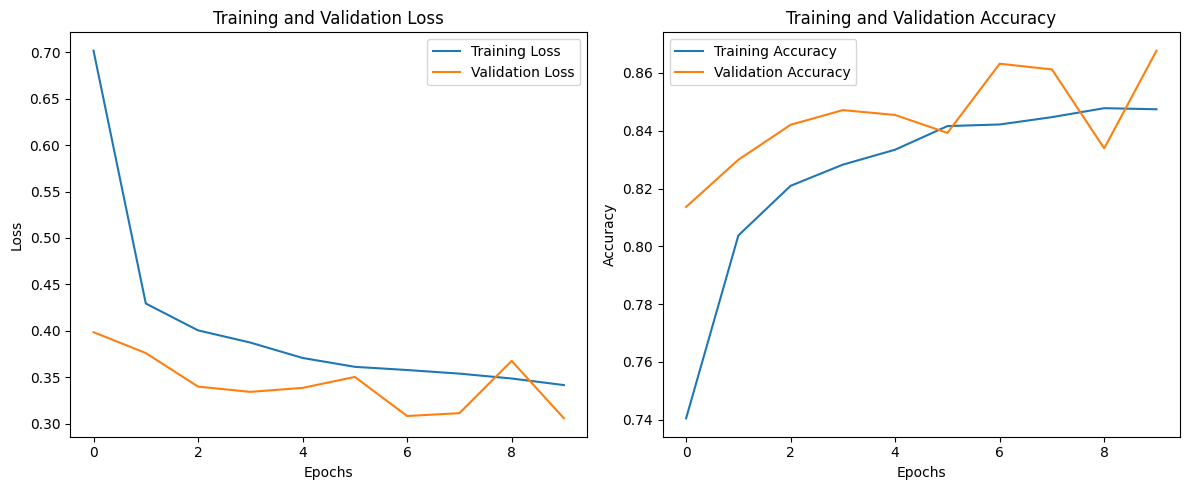

In [11]:
epochs = 10
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // batch_size
)

plt = generate_plot(history)
plt.show()

## unfreeze last layers & train again (same model!)



In [13]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [14]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer="rmsprop",
              metrics=['accuracy']
)

Epoch 1/5
333/333 [==============================] - 283s 838ms/step - loss: 1.9083 - accuracy: 0.6839 - val_loss: 0.4531 - val_accuracy: 0.7776
Epoch 2/5
333/333 [==============================] - 280s 842ms/step - loss: 0.4310 - accuracy: 0.8157 - val_loss: 0.3952 - val_accuracy: 0.8511
Epoch 3/5
333/333 [==============================] - 278s 835ms/step - loss: 0.3710 - accuracy: 0.8410 - val_loss: 0.4371 - val_accuracy: 0.8314
Epoch 4/5
333/333 [==============================] - 257s 773ms/step - loss: 0.3387 - accuracy: 0.8641 - val_loss: 0.2782 - val_accuracy: 0.8927
Epoch 5/5
333/333 [==============================] - 275s 826ms/step - loss: 0.3217 - accuracy: 0.8686 - val_loss: 0.2775 - val_accuracy: 0.8854


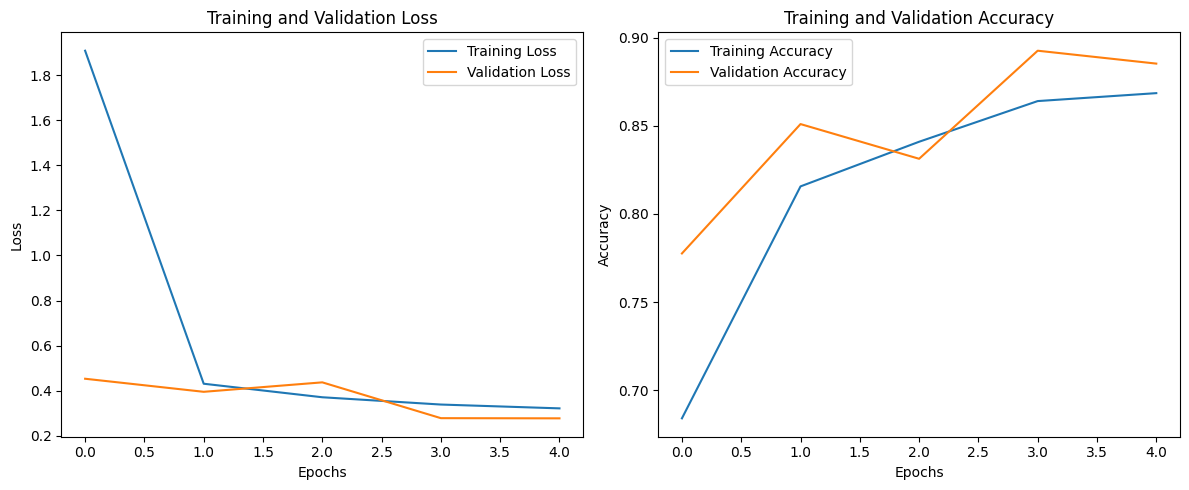

In [15]:
epochs = 5
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset.samples // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=validation_dataset.samples // batch_size
)

plt = generate_plot(history)
plt.show()